<a href="https://colab.research.google.com/github/LeonardoSanBenitez/Unlearn-Saliency/blob/master/PEM_composition_img_gen/01_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

is_colab: bool = 'google.colab' in sys.modules

if is_colab:
    # You need to manually create the .env file
    %cd /content
    !pip install python-dotenv
    import dotenv
    dotenv.load_dotenv()

    import os
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    # TODO: install the dependencies from our repo, not from difusers
    if not os.path.exists('diffusers'):
        !git clone https://github.com/huggingface/diffusers
    %cd diffusers
    !pip install .
    !pip install torchmetrics

    %cd examples/text_to_image
    !pip install -r requirements.txt

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default

    %cd /content/
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd /content/Unlearn-Saliency/PEM_composition_img_gen
elif "alumnos" in os.getcwd():
    %cd ~
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd ~/Unlearn-Saliency/PEM_composition_img_gen

    !python3.10 -m pip install poetry~=1.2
    !python3.10 -m poetry config virtualenvs.create true

    if os.path.exists("poetry.lock"):
        !rm poetry.lock
    !sed -i 's/python = "~3.11"/python = "~3.10"/' ./pyproject.toml
    !python3.10 -m poetry install --no-root --no-interaction --no-ansi
    
    import dotenv
    dotenv.load_dotenv()
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default
else:
    sys.path.append('..')

In [2]:
model_base_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"


In [3]:
import datasets
from PIL import Image
import matplotlib.pyplot as plt
import random
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from typing import Literal, List, Dict, Tuple, Optional, Callable, Union

import os
import sys
import shutil

from libs.datasets import UnlearnDatasetImagenette, UnlearnDatasetCifar, UnlearnDatasetSplitMode


# Download dataset

In [8]:
#if os.path.exists('assets/imagenette_splits'):
#    shutil.rmtree('assets/imagenette_splits')
if not os.path.exists('assets/imagenette_splits'):
    for c in UnlearnDatasetImagenette.class_mapping:
        print('-'*80)
        print('Forgetting', UnlearnDatasetImagenette.class_mapping[c])
        dataset = UnlearnDatasetImagenette(
            split_mode=UnlearnDatasetSplitMode.Class,
            split_kwargs={"forget": [c]},
            download_path="assets/imagenette",
        )
        dataset.save(f"assets/imagenette_splits/{c}", format='jpg')


# Train

In [19]:
for c in UnlearnDatasetImagenette.class_mapping:
    print('-'*80)
    print('Training', UnlearnDatasetImagenette.class_mapping[c])
    train_data_dir = f"./assets/imagenette_splits/{c}/train_forget"
    output_dir = f"./assets/lora/imagenette_splits/{c}"  # Local output
    
    !accelerate launch --mixed_precision="fp16" --num_processes 1 --num_machines 1 --dynamo_backend "no" train_text_to_image_lora.py \
        --pretrained_model_name_or_path={model_base_name} \
        --train_data_dir={train_data_dir} \
        --dataloader_num_workers=2 \
        --resolution=512 \
        --mixed_precision "fp16" \
        --train_batch_size=4 \
        --gradient_accumulation_steps=8 \
        --learning_rate=8e-04 \
        --max_grad_norm=1 \
        --lr_scheduler="cosine" \
        --lr_warmup_steps=0 \
        --output_dir={output_dir} \
        --num_train_epochs=1 \
        --validation_epochs=1 \
        --checkpointing_steps=500 \
        --validation_prompt="A sunset painting." \
        --num_validation_images=1 \
        --seed=42
    break

--------------------------------------------------------------------------------
Training tench
Namespace(pretrained_model_name_or_path='stable-diffusion-v1-5/stable-diffusion-v1-5', lora_name_or_path=None, revision=None, variant=None, dataset_name=None, dataset_config_name=None, train_data_dir='./assets/imagenette_splits/n01440764/train_forget', image_column='image', caption_column='text', validation_prompt='A sunset painting.', num_validation_images=1, validation_epochs=1, max_train_samples=None, output_dir='./assets/lora/imagenette_splits/n01440764', cache_dir=None, seed=42, resolution=512, center_crop=False, random_flip=False, train_batch_size=4, num_train_epochs=5, max_train_steps=None, gradient_accumulation_steps=8, gradient_checkpointing=False, learning_rate=0.0008, scale_lr=False, lr_scheduler='cosine', lr_warmup_steps=0, snr_gamma=None, use_8bit_adam=False, allow_tf32=False, dataloader_num_workers=2, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08,

# Evaluation

In [ ]:
#!pip install image_similarity_measures lpips
from libs.metrics.image_and_text import MetricImageTextSimilarity
metric = MetricImageTextSimilarity(metrics=['clip'])

In [18]:
output_dir

'./assets/lora/imagenette_splits/n01440764'

--------------------------------------------------------------------------------
Evaluating tench


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating english_springer


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating cassette_player


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating chain_saw


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating church


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating french_horn


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating garbage_truck


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating gas_pump


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating golf_ball


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating parachute


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

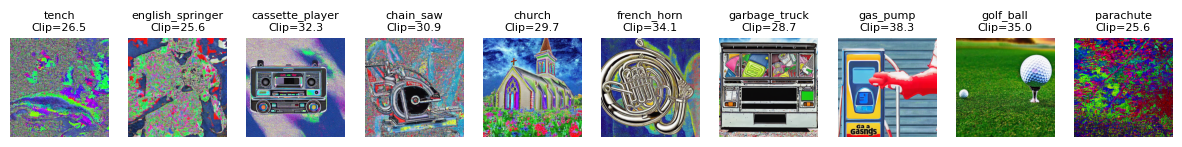

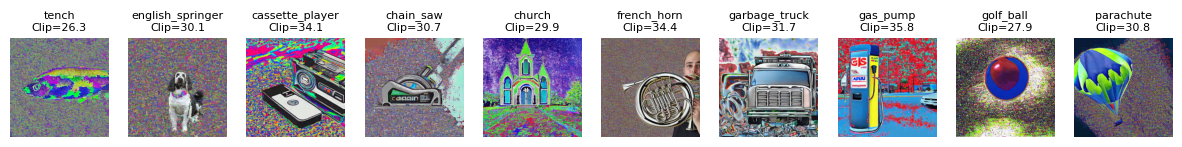

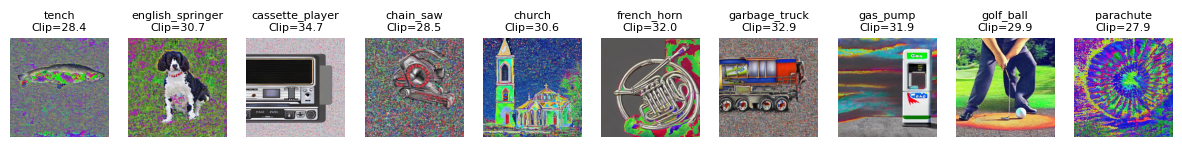

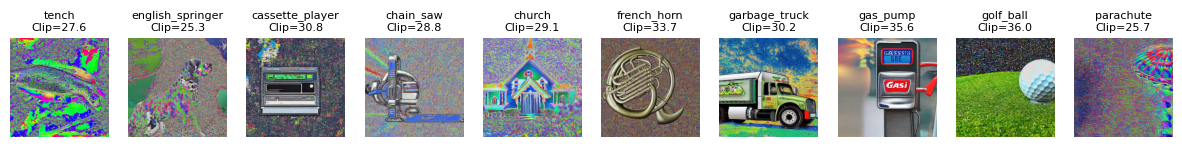

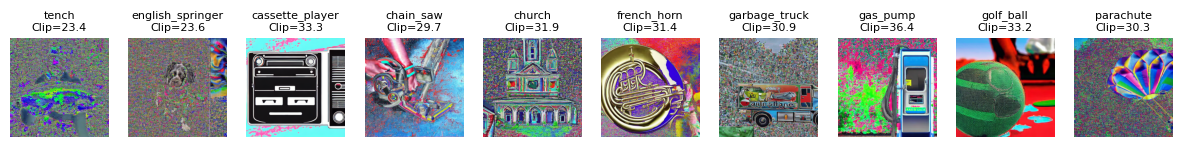

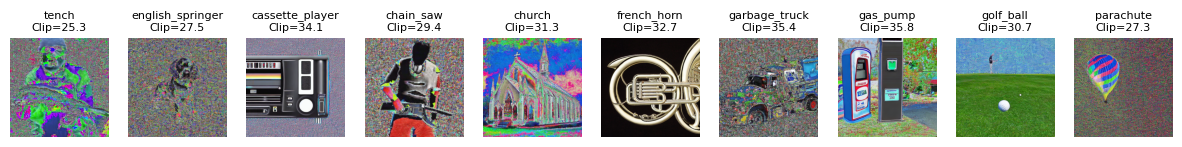

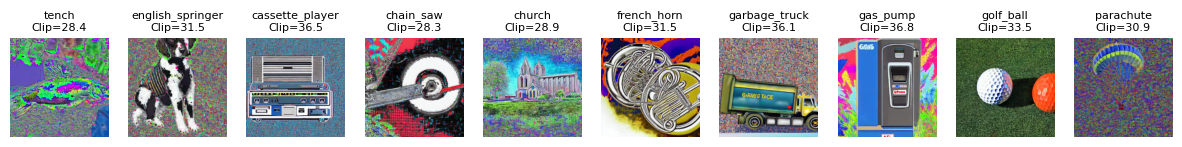

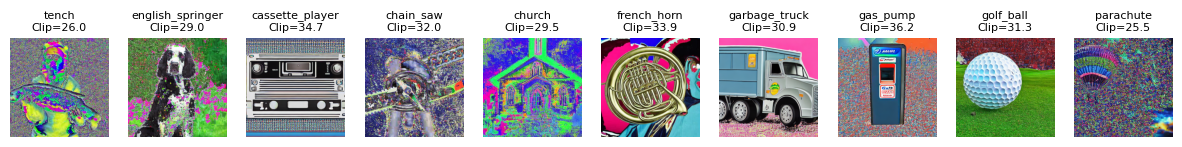

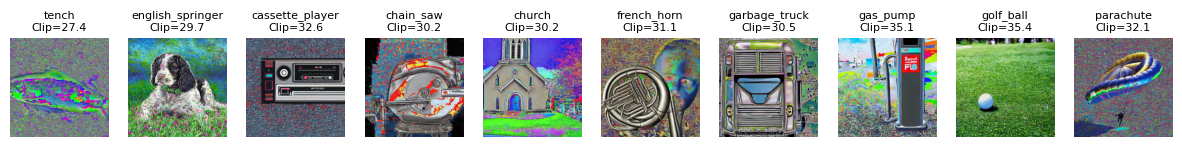

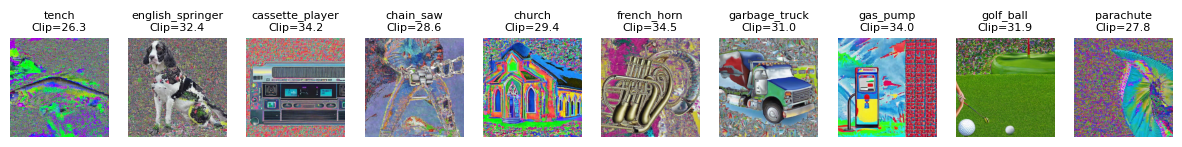

In [20]:
for class_model in UnlearnDatasetImagenette.class_mapping:
    print('-'*80)
    print('Evaluating', UnlearnDatasetImagenette.class_mapping[class_model])

    output_dir = f"./assets/lora/imagenette_splits/{class_model}"
    pipeline_unlearned = AutoPipelineForText2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")
    pipeline_unlearned.load_lora_weights(output_dir, weight_name="pytorch_lora_weights.safetensors")

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for col, class_eval in enumerate(UnlearnDatasetImagenette.class_mapping):
        prompt = f"An image of {UnlearnDatasetImagenette.class_mapping[class_eval]}"
        image = pipeline_unlearned(prompt).images[0]
        score_clip: float = metric.score(image, prompt)['clip']

        axes[col].imshow(image)
        axes[col].set_title(f"{UnlearnDatasetImagenette.class_mapping[class_eval]}\nClip={score_clip:.1f}", fontsize=8)
        axes[col].axis("off")
    plt.plot()
    #break